# Лабораторная работа №2 — Линейная классификация

**Тема:** Сравнение логистической регрессии с деревьями (RandomForestClassifier) и градиентным бустингом (XGBoost) на задаче классификации.

## Цели

- Построить, оптимизировать и оценить классификаторы.
- Понять интерпретацию признаков (веса, permutation importance).
- Освоить расширение и отбор признаков (feature tuning).
- Изучить влияние регуляризации, калибровки и гиперпараметров.

## Условия

- numpy, pandas, scikit-learn, XGBoost
- использовать тот же датасет, что в ЛР1 (если возможно), но с целевой переменной для классификации

## План (пункты лабораторной)

1. **Подготовка данных + Feature Tuning**
   - Стратифицированное разбиение; обработка пропусков; OneHotEncoder для категориальных, StandardScaler для численных; базовый feature engineering (минимум 3 новых признака).
2. **Метрики**
   - Accuracy, Precision/Recall/F1 (macro/weighted), ROC-AUC, PR-AUC (для дисбаланса), LogLoss; confusion matrix.
3. **Базовая логистическая регрессия**
   - Pipeline: препроцессинг + LogisticRegression(penalty="l2"); вывести все метрики.
4. **Улучшение логистической регрессии**
   - Тюнинг C, class_weight="balanced", подбор порога по валидации, калибровка вероятностей (CalibratedClassifierCV), сравнение метрик до/после.
5. **RandomForestClassifier**
   - Базовая и тюнинг (n_estimators, max_depth, min_samples_leaf, max_features); метрики как в п.2.
6. **XGBoostClassifier**
   - Базовая и тюнинг (learning_rate, n_estimators, max_depth, subsample, colsample_bytree; early stopping); метрики как в п.2.
7. **Feature Importance**
   - Веса логистики (|w|), встроенная важность деревьев/бустинга, permutation importance; сравнить топ-признаки.
8. **Свои реализации (классы)**
   - MyLogisticRegression (GD/SGD, L2, OVR) и/или MyPerceptron/MyLinearSVM; сравнить с sklearn по метрикам.
9. **Подведение итогов**
   - Таблица метрик всех моделей, лучшие гиперпараметры, графики (ROC/PR, важности, метрика-vs-порог), краткие выводы о качестве/интерпретируемости/стоимости ошибок.

## О команде

| Фамилия И.О.        | Группа | Роль в команде | Что делал                    |
|---------------------|--------|----------------|------------------------------|
| Пермяков Г.А.         | 307    | data-scientist | EDA       |
| Ивченко М. С.        | 307    | data-scientist | feature tuning      |
| Крушинин Н. Г.         | 307    | data-scientist | обучение + класс лин регрессии       |

 Датасет: [Earthquake Alert Prediction Dataset](https://www.kaggle.com/datasets/ahmeduzaki/earthquake-alert-prediction-dataset)

## Описание датасета

Данный набор данных содержит сведения о землетрясениях с 1 января 2001 года по 1 января 2023 года.  
Источник: [Kaggle — Earthquake Dataset](https://www.kaggle.com/datasets/warcoder/earthquake-dataset)

Каждая запись описывает событие землетрясения и содержит следующие столбцы:

| № | Название столбца | Тип данных / формат | Описание |
|---|------------------|---------------------|----------|
| 1 | title          | строка             | Название события землетрясения |
| 2 | magnitude      | число (float)      | Величина магнитуды землетрясения |
| 3 | date_time      | дата-время (string) | Дата и время события |
| 4 | cdi            | число (float)      | Максимальная зарегистрированная интенсивность (felt reports) |
| 5 | mmi            | число (float)      | Максимальная рассчитанная инструментальная интенсивность (Modified Mercalli Instrumental) |
| 6 | alert          | строка             | Уровень предупреждения — «green», «yellow», «orange», «red» |
| 7 | tsunami        | целое (0/1)        | Индикатор: 1 — если событие сопровождалось цунами; 0 — иначе |
| 8 | sig            | число (integer)    | Показатель значимости события (чем больше — тем значимее) |
| 9 | net            | строка             | Идентификатор сети, которая является основным источником данных |
|10 | nst            | целое              | Количество сейсмических станций, использованных для определения местоположения события |
|11 | dmin           | число (float)      | Горизонтальное расстояние от эпицентра до ближайшей станции |
|12 | gap            | число (float)      | Наибольший азимутальный разрыв между соседними сейсмическими станциями (в градусах) |
|13 | magType        | строка             | Метод или алгоритм, использованный для определения магнитуды |
|14 | depth          | число (float)      | Глубина, на которой началось землетрясение (в километрах) |
|15 | latitude       | число (float)      | Широта эпицентра события |
|16 | longitude      | число (float)      | Долгота эпицентра события |
|17 | location       | строка             | Описание местоположения события внутри страны или региона |
|18 | continent      | строка             | Континент, на котором произошло событие |
|19 | country        | строка             | Страна, затронутая событием |

### Целевая переменная

- **alert** — при задаче классификации уровней предупреждения землетрясения  
- **tsunami** — при бинарной задаче предсказания возможности возникновения цунами  

### Комментарии  
- Некоторые столбцы могут содержать пропущенные значения, поэтому перед анализом или обучением моделей рекомендуется выполнить очистку данных.  
- Для задач регрессии или классификации можно выбрать подходящую целевую переменную.  
- Столбцы latitude, longitude, depth, magnitude и другие могут быть использованы как признаки геолокации и интенсивности события.


# 0. Глобавльная настройка

In [ ]:
RND_SEED = 42


In [ ]:
!pip install kagglehub kagglehub[pandas-datasets] --quiet
!pip install jupyter ipywidgets --upgrade --quiet


# ! Подготовка данных 

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "earthquake_data.csv"

# Load the latest version
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "warcoder/earthquake-dataset",
    file_path,
    # Provide any additional arguments like
    # sql_query or pandas_kwargs. See the
    # documenation for more information:
    # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


посмотрим первые 5 строк датасета `df.head(n: int = 5)`


In [ ]:
df.head()


title  magnitude         date_time  \
0  M 7.0 - 18 km SW of Malango, Solomon Islands        7.0  22-11-2022 02:03   
1      M 6.9 - 204 km SW of Bengkulu, Indonesia        6.9  18-11-2022 13:37   
2                                      M 7.0 -         7.0  12-11-2022 07:09   
3           M 7.3 - 205 km ESE of Neiafu, Tonga        7.3  11-11-2022 10:48   
4                                      M 6.6 -         6.6  09-11-2022 10:14   

   cdi  mmi  alert  tsunami  sig net  nst   dmin   gap magType    depth  \
0    8    7  green        1  768  us  117  0.509  17.0     mww   14.000   
1    4    4  green        0  735  us   99  2.229  34.0     mww   25.000   
2    3    3  green        1  755  us  147  3.125  18.0     mww  579.000   
3    5    5  green        1  833  us  149  1.865  21.0     mww   37.000   
4    0    2  green        1  670  us  131  4.998  27.0     mww  624.464   

   latitude  longitude                  location continent          country  
0   -9.7963    159.596  Malango, Solomon Islands   Oceania  Solomon Islands  
1   -4.9559    100.738       Bengkulu, Indonesia       NaN              NaN  
2  -20.0508   -178.346                       NaN   Oceania             Fiji  
3  -19.2918   -172.129             Neiafu, Tonga       NaN              NaN  
4  -25.5948    178.278                       NaN       NaN              NaN

### 1.2 Сбор основной информации о данных

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      782 non-null    object 
 1   magnitude  782 non-null    float64
 2   date_time  782 non-null    object 
 3   cdi        782 non-null    int64  
 4   mmi        782 non-null    int64  
 5   alert      415 non-null    object 
 6   tsunami    782 non-null    int64  
 7   sig        782 non-null    int64  
 8   net        782 non-null    object 
 9   nst        782 non-null    int64  
 10  dmin       782 non-null    float64
 11  gap        782 non-null    float64
 12  magType    782 non-null    object 
 13  depth      782 non-null    float64
 14  latitude   782 non-null    float64
 15  longitude  782 non-null    float64
 16  location   777 non-null    object 
 17  continent  206 non-null    object 
 18  country    484 non-null    object 
dtypes: float64(6), int64(5), object(8)
memory usage: 1

Проверка наличия пропусков

In [ ]:
df.isnull().sum()


title          0
magnitude      0
date_time      0
cdi            0
mmi            0
alert        367
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       5
continent    576
country      298
dtype: int64

### Выводы по пропускам (summary)

Ниже приведена сводка по пропускам в датасете (колонки и число пропусков):

- title: 0
- magnitude: 0
- date_time: 0
- cdi: 0
- mmi: 0
- alert: 367
- tsunami: 0
- sig: 0
- net: 0
- nst: 0
- dmin: 0
- gap: 0
- magType: 0
- depth: 0
- latitude: 0
- longitude: 0
- location: 5
- continent: 576
- country: 298

Ключевые выводы и рекомендации по обработке:

1. Колонки без пропусков (использовать напрямую):
    - title, magnitude, date_time, cdi, mmi, tsunami, sig, net, nst, dmin, gap, magType, depth, latitude, longitude.

2. Колонка `alert` — 367 пропусков:
    - `alert` является целевой переменной (target), строки с пропусками лучше исключить из обучающей выборки или выделить в отдельный набор для последующей разметки/аннотации.
    - Можно попробовать использовать приёмы semisupervised-learning

3. `continent` (576 пропусков) и `country` (298 пропусков):
    - Значительный объём пропусков. Рекомендуется попытаться восстановить значения по координатам (`latitude`, `longitude`) с помощью обратного геокодинга (reverse geocoding) или готовых геоинформационных таблиц.
    - Если восстановление невозможно, заменить на `unknown` и добавить флаги `is_country_missing` / `is_continent_missing`.

4. `location` — 5 пропусков:
    - Небольшое количество; можно удалить эти строки или заполнить на основе `country`/`continent`/координат.

5. Общая стратегия обработки (приоритеты):
    - Сначала попытаться восстановить `country`/`continent` по координатам (это даёт наилучшее качество признаков).
    - Если `alert` — таргет: удалить/отложить строки с пропущенным `alert` для обучения; если нет — заполнить `unknown` + индикатор пропуска.
    - Для всех категориальных признаков с пропусками (country/continent/alert при необходимости) добавить бинарные индикаторы наличия пропуска — это помогает деревьям и линейным моделям.
    - Зафиксировать все шаги предобработки (скрипты, random_state) для воспроизводимости.

6. Примечание по валидации:
    - При восстановлении значений по координатам проверять корректность (например, случайные сэмплы) — обратное геокодирование может давать ошибки на границах.
    - При удалении строк с таргетом учитывать, как это повлияет на баланс классов (особенно если некоторые классы уже редкие).

Краткий практический план действий:

- Попытаться геокодировать `country`/`continent` по `latitude`/`longitude`.
- Если `alert` — target: удалить 367 строк с пустым `alert` или пометить их отдельно для ручной разметки.
- Заполнить оставшиеся пропуски категорией `unknown` и добавить бинарные индикаторы пропуска.
- Зафиксировать random_state и сохранить логи предобработки для воспроизводимости.

In [ ]:
df.describe()


magnitude         cdi         mmi     tsunami          sig  \
count  782.000000  782.000000  782.000000  782.000000   782.000000   
mean     6.941125    4.333760    5.964194    0.388747   870.108696   
std      0.445514    3.169939    1.462724    0.487778   322.465367   
min      6.500000    0.000000    1.000000    0.000000   650.000000   
25%      6.600000    0.000000    5.000000    0.000000   691.000000   
50%      6.800000    5.000000    6.000000    0.000000   754.000000   
75%      7.100000    7.000000    7.000000    1.000000   909.750000   
max      9.100000    9.000000    9.000000    1.000000  2910.000000   

              nst        dmin         gap       depth    latitude   longitude  
count  782.000000  782.000000  782.000000  782.000000  782.000000  782.000000  
mean   230.250639    1.325757   25.038990   75.883199    3.538100   52.609199  
std    250.188177    2.218805   24.225067  137.277078   27.303429  117.898886  
min      0.000000    0.000000    0.000000    2.700000  -61.848400 -179.968000  
25%      0.000000    0.000000   14.625000   14.000000  -14.595600  -71.668050  
50%    140.000000    0.000000   20.000000   26.295000   -2.572500  109.426000  
75%    445.000000    1.863000   30.000000   49.750000   24.654500  148.941000  
max    934.000000   17.654000  239.000000  670.810000   71.631200  179.662000

### Краткий анализ описательной статистики (по таблице)

Ниже — выводы, основанные на представленной статистике по числовым признакам:

- Объём: все числовые признаки содержат 782 наблюдения (совпадает с общим числом записей).
- Магнитуда (`magnitude`): диапазон 6.5–9.1, медиана 6.8 — распределение компактное (std ≈ 0.45). Это указывает на выборку преимущественно сильных землетрясений.
- CDI / MMI (`cdi`, `mmi`): медианы 5 и 6 соответственно, но `cdi` содержит много нулей (min=0, 25% = 0) — нужно проверить смысл нулей (неотвеченные репорты или отсутствующие оценки). `mmi` варьируется сильнее (std ≈ 1.46).
- Tsunami (`tsunami`): бинарный признак с mean ≈ 0.39 → около 39% событий сопровождались цунами.
- Sig (`sig`): очень широкое распределение (mean ≈ 870, max = 2910) — сильные вариации значимости событий; возможны экстремальные значения, которые стоит проверить как потенциальные выбросы.
- Nst (`nst`): среднее ≈ 230, но std большой (≈250), медиана 140, максимум 934 — много разброса в числе станций, использованных для локации; учесть при качественной оценке локаций.
- dmin, gap: медиана `dmin` = 0 (много небольших расстояний до ближайшей станции), `gap` медиана = 20°, но max=239° — случаи с очень большим азимутальным разрывом (плохая геометрия станций) могут давать ненадёжные локализации.
- Depth (`depth`): среднее ≈ 75.9, но огромный std ≈137 и max = 670.81 — присутствуют явно выбивающиеся значения по глубине, стоит проверить единицы измерения и рассмотреть отсечение/капирование или фильтрацию некорректных глубин.
- География (`latitude`, `longitude`): диапазоны охватывают почти весь возможный спектр (lat: -61.85 … 71.63, lon: -179.968 … 179.662) — глобальная выборка.

Рекомендации по предобработке данных на этапе обучения моделей:

1. Проверить нули в `cdi` — отличить реальные нулевые наблюдения от пропусков/отсутствия данных. При необходимости заполнить или пометить бинарным флагом.
2. Для `depth` выбрать стратегию обработки выбросов: логарифмирование (если смыслово), отсечение по разумным границам (например, 0–700 км, но проверить источники) или замена экстремумов на медиану/квантиль.
3. Для `sig` и `nst` рассмотреть лог-преобразование или нормирование перед линейными моделями; для деревьев — оставить как есть, добавив при необходимости биннинг.
4. Для `gap` и `dmin` пометить экстремальные значения (например, gap > 180°) и, возможно, исключить такие локации из задач, требующих точной геометрии измерений.
5. Масштабирование: для линейных моделей и логистики применить StandardScaler к признакам с большой дисперсией (`sig`, `nst`, `depth`); для RandomForest/XGBoost масштабирование не обязательно.
6. Сохранить результаты проверки и исправлений (логи), а также фиксировать `random_state` при генерации обучающих/тестовых выборок для воспроизводимости.

Эти шаги помогут снизить влияние выбросов и неконсистентных измерений и улучшат стабильность моделей при классификации уровней оповещения.

посмотрим на распределение целевой переменной

/tmp/ipykernel_193347/2325648769.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values,
/tmp/ipykernel_193347/2325648769.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values,


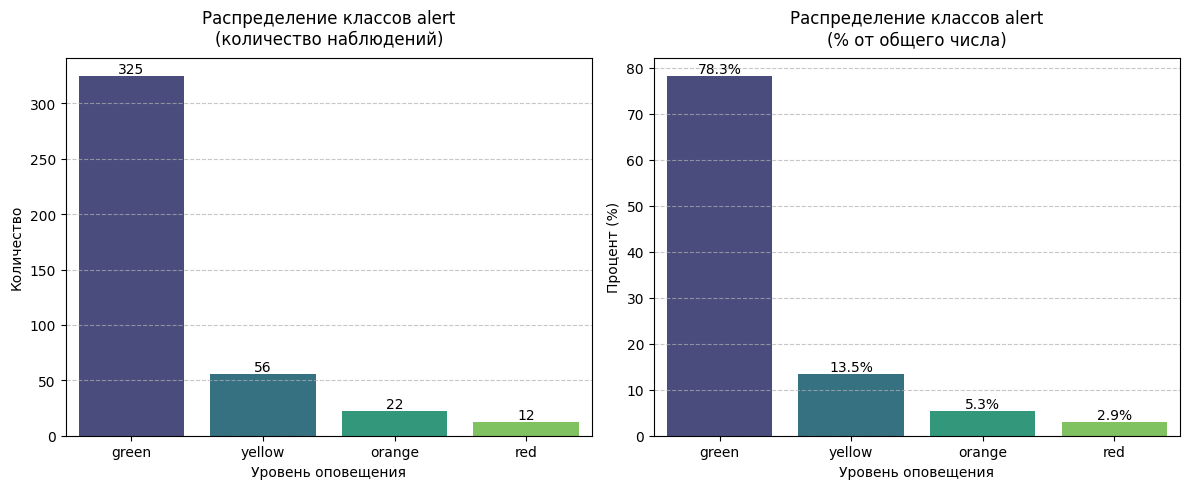


Сводка по распределению классов:
        Количество  Процент (%)
alert                          
green          325        78.31
yellow          56        13.49
orange          22         5.30
red             12         2.89


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_target_distribution(df, target_col="alert", figsize=(12, 5)):
    """
    Строит распределение целевой переменной (классов alert) в виде двух графиков:
    1. Количество наблюдений по классам
    2. Процентное соотношение классов

    Parameters:
    -----------
    df : pd.DataFrame
        Датасет с данными
    target_col : str
        Название целевой переменной (по умолчанию 'alert')
    figsize : tuple
        Размер графика (ширина, высота)
    """
    # Создаем фигуру с двумя графиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Считаем значения для графиков
    value_counts = df[target_col].value_counts()
    percentages = df[target_col].value_counts(normalize=True) * 100

    # График 1: Количество наблюдений
    sns.barplot(x=value_counts.index, y=value_counts.values,
                palette='viridis', ax=ax1)
    ax1.set_title('Распределение классов alert\n(количество наблюдений)',
                  fontsize=12, pad=10)
    ax1.set_xlabel('Уровень оповещения')
    ax1.set_ylabel('Количество')

    # Добавляем значения над столбцами
    for i, v in enumerate(value_counts.values):
        ax1.text(i, v, str(v), ha='center', va='bottom')

    # График 2: Процентное соотношение
    sns.barplot(x=percentages.index, y=percentages.values,
                palette='viridis', ax=ax2)
    ax2.set_title('Распределение классов alert\n(% от общего числа)',
                  fontsize=12, pad=10)
    ax2.set_xlabel('Уровень оповещения')
    ax2.set_ylabel('Процент (%)')

    # Добавляем процентные значения над столбцами
    for i, v in enumerate(percentages.values):
        ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

    # Общие настройки
    for ax in [ax1, ax2]:
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')
        plt.setp(ax.get_xticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()

    # Выводим текстовую сводку
    print("\nСводка по распределению классов:")
    summary_df = pd.DataFrame({
        'Количество': value_counts,
        'Процент (%)': percentages
    }).round(2)
    print(summary_df)


plot_target_distribution(df)


**Выводы по распределению целевой переменной:**

Наблюдается существенный дисбаланс классов в исходных данных:

1. Распределение по классам:
   - `green`: 325 наблюдений (78.31%) — доминирующий класс
   - `yellow`: 56 наблюдений (13.49%)
   - `orange`: 22 наблюдения (5.30%)
   - `red`: 12 наблюдений (2.89%) — наиболее редкий класс

2. Рекомендации по работе с дисбалансом:
   - Использовать стратифицированное разбиение при создании train/test выборок (чтобы сохранить пропорции классов)
   - Применить техники балансировки:
     - SMOTE/ADASYN для синтеза дополнительных примеров миноритарных классов (`red`, `orange`)
     - RandomUndersampling для мажоритарного класса (`green`)
     - или комбинированные подходы (SMOTETomek, SMOTEENN)
   
3. Корректировки для обучения:
   - Использовать `class_weight="balanced"` в моделях, поддерживающих взвешивание
   - Оценивать качество по macro/weighted метрикам (F1, ROC-AUC)
   - При необходимости настроить пороги классификации на валидационной выборке

4. Важно: обратить особое внимание на правильную классификацию редких, но критичных классов (`red`, `orange`), так как они могут соответствовать наиболее опасным сейсмическим событиям.

Проверим распределение оставшихся признаков

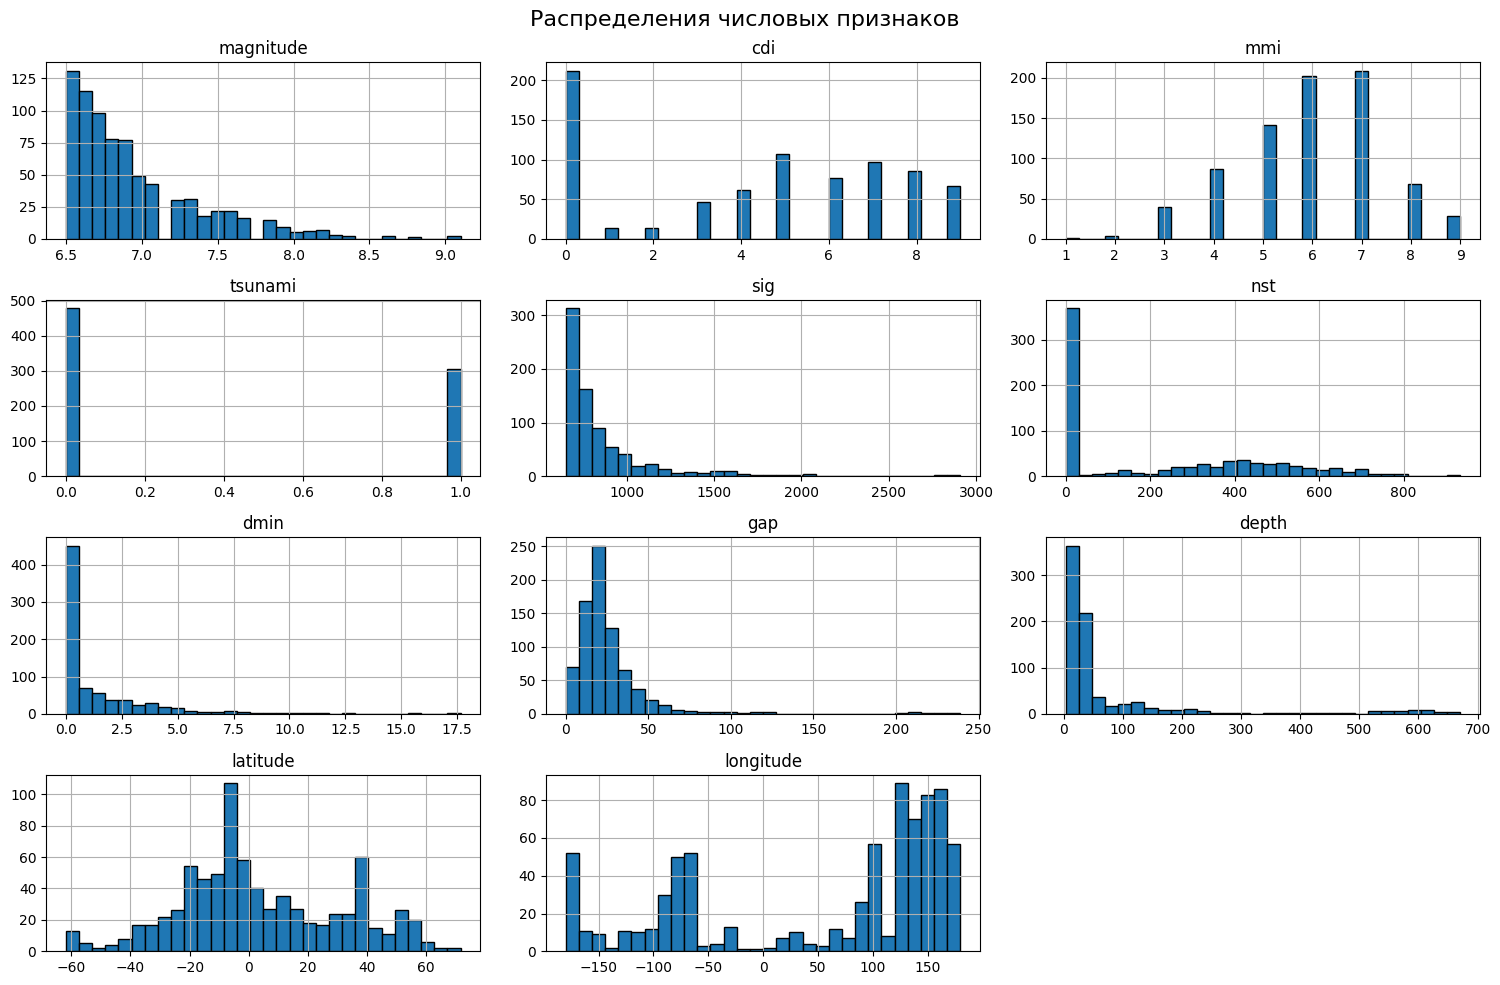

In [ ]:
df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Распределения числовых признаков", fontsize=16)
plt.tight_layout()
plt.show()


построим карту с помощью folium где будут отображены точки землетрясений с разным уровнем 

In [ ]:
import folium
import pandas as pd

# Цвета для классов alert
alert_colors = {
    "green": "green",
    "yellow": "orange",
    "orange": "red",
    "red": "darkred"
}

# Центр карты — средние координаты
center_lat = df["latitude"].mean()
center_lon = df["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color=alert_colors.get(str(row["alert"]).lower(), "gray"),
        fill=True,
        fill_color=alert_colors.get(str(row["alert"]).lower(), "gray"),
        fill_opacity=0.7,
        popup=f"Магнитуда: {row['magnitude']}, Alert: {row['alert']}"
    ).add_to(m)

m


Посмотрим на корреляцию данных.

***Определение 1: Корреляция данных — это статистическая мера, показывающая, насколько и в каком направлении связаны между собой две переменные.***

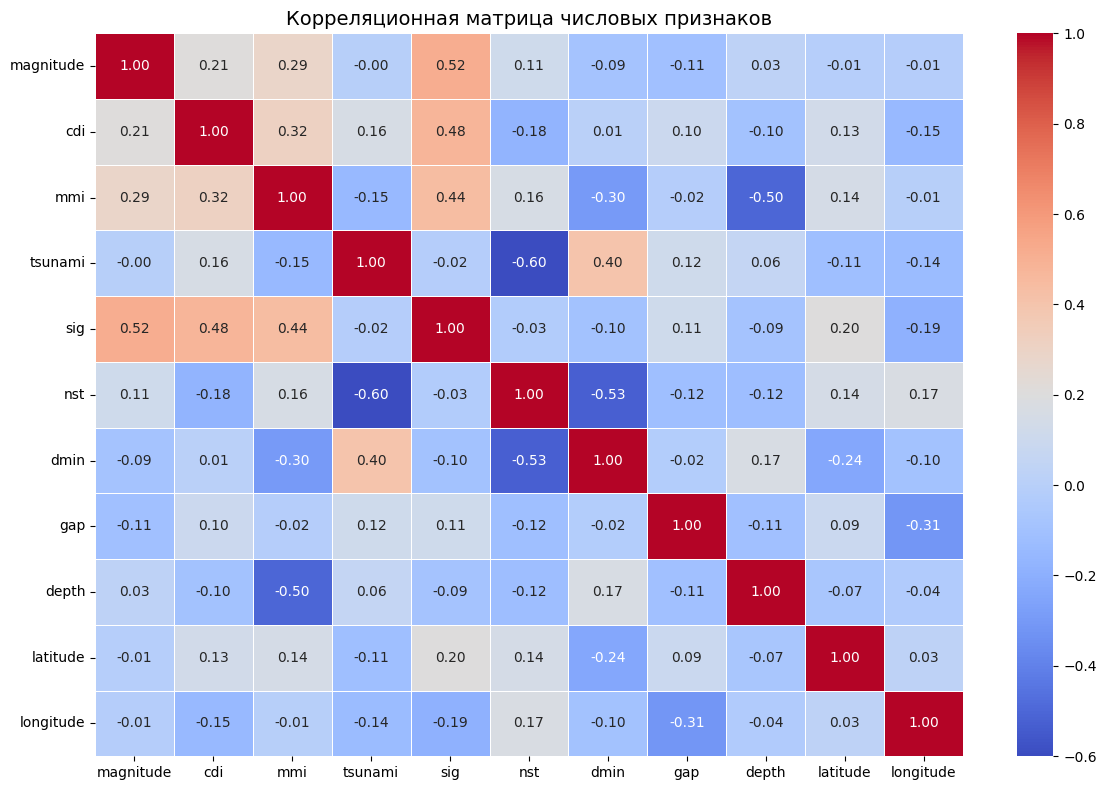

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def draw_corr_matrix(df):
    """
    Строит корреляционную матрицу только для числовых признаков.
    """
    df_numeric = df.select_dtypes(include=['number'])
    plt.figure(figsize=(12, 8))
    corr = df_numeric.corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Корреляционная матрица числовых признаков", fontsize=14)
    plt.tight_layout()
    plt.show()


# Вызов для вашего датасета
draw_corr_matrix(df)


## 📊 1.3. Подготовка датасета под разные модели (Earthquake Alert)

| Модель                  | Масштабирование | Корреляция критична | Выбросы критичны | Feature Engineering рекомендуем                                   |
| ----------------------- | --------------- | ------------------- | ---------------- | ----------------------------------------------------------------- |
| **Логистическая регрессия**  | Да              | Да                  | Да               | Логарифмирование числовых признаков (например, `sig`, `depth`), полиномы по `magnitude`, отношения (`sig/nst`, `depth/magnitude`) |
| **Random Forest**       | Нет             | Нет                 | Нет              | Соотношения (например, `sig/nst`, `depth/magnitude`), бинаризация категориальных признаков (`alert`, если используется как feature) |
| **XGBoost**             | Нет             | Нет                 | Нет              | Соотношения, логарифмирование числовых признаков (опционально), интеракции `magnitude × depth`, `sig × tsunami` |

---

## ✅ TODO для второго человека (Feature Engineering)

1. **Пропуски и выбросы**
   - Заполнить пропуски в категориальных признаках (`country`, `continent`, `alert`) — например, значением `'unknown'` и добавить бинарные индикаторы пропуска.
   - Проверить выбросы в числовых признаках (`depth`, `sig`, `nst`), скорректировать при необходимости (логарифмирование, капирование, удаление экстремумов).

2. **Создание новых признаков**
   - `sig_per_station = sig / nst`
   - `depth_per_magnitude = depth / magnitude`
   - `tsunami_flag = int(tsunami > 0)`

3. **Географические фичи**
   - Закодировать категориальные признаки (`country`, `continent`) через One-Hot Encoding.
   - Опционально: добавить кластеризацию по координатам (`latitude`, `longitude`) для выявления региональных паттернов.

4. **Преобразования целевой переменной**
   - Для задач бинарной классификации: объединить редкие классы (`red`, `orange`) в одну категорию, если требуется.
   - Для многоклассовой: сохранить оригинальные категории, использовать стратификацию при разбиении.

5. **Нормализация**
   - Масштабировать числовые признаки (StandardScaler / MinMaxScaler) — **только для линейных моделей**.
   - Для деревьев и бустингов масштабирование не требуется.

In [ ]:
import numpy as np


class GridMedianTransformer:
    def __init__(self, n_bins=100, target_col="alert", new_feature_name="grid_mod_alert"):
        """
        n_bins: количество ячеек по каждой оси (по умолчанию 100 → 100x100 сетка)
        target_col: имя целевой переменной в обучающем датасете (для расчёта медиан)
        new_feature_name: имя нового признака в выходном DataFrame
        """
        self.n_bins = n_bins
        self.target_col = target_col
        self.new_feature_name = new_feature_name
        self.lat_edges = None
        self.lon_edges = None
        self.grid_medians = None  # Series с мультииндексом (lat_bin, lon_bin)
        self.global_median = None

    def fit(self, X, y=None):
        """
        X: DataFrame с колонками 'latitude', 'longitude' и (если y=None) target_col
        y: опционально — отдельный Series с целевой переменной
        """
        df = X.copy()

        if y is not None:
            df[self.target_col] = y.values
        elif self.target_col not in df.columns:
            raise ValueError(
                f"Target column '{self.target_col}' must be in X or provided via y")

        # Сохраняем глобальную медиану на случай точек вне сетки
        self.global_median = df[self.target_col].median()

        # Границы бинов — фиксируем по обучающим данным
        self.lat_edges = np.linspace(
            df["latitude"].min(), df["latitude"].max(), self.n_bins + 1)
        self.lon_edges = np.linspace(
            df["longitude"].min(), df["longitude"].max(), self.n_bins + 1)

        # Бинируем координаты
        df["lat_bin"] = pd.cut(
            df["latitude"], bins=self.lat_edges, labels=False, include_lowest=True)
        df["lon_bin"] = pd.cut(
            df["longitude"], bins=self.lon_edges, labels=False, include_lowest=True)

        # Удаляем строки, где бин не определён (маловероятно, но возможно)
        df = df.dropna(subset=["lat_bin", "lon_bin"]).copy()
        df["lat_bin"] = df["lat_bin"].astype(int)
        df["lon_bin"] = df["lon_bin"].astype(int)

        # Агрегация: медиана по ячейкам
        self.grid_medians = (
            df.groupby(["lat_bin", "lon_bin"])[self.target_col]
            .median()
        )
        return self

    def transform(self, X):
        """
        X: DataFrame с колонками 'latitude', 'longitude'
        Возвращает: новый DataFrame без 'latitude', 'longitude',
                    с добавленной колонкой self.new_feature_name
        """
        if self.lat_edges is None or self.lon_edges is None:
            raise ValueError(
                "Transformer has not been fitted yet. Call fit() first.")

        df = X.copy()

        # Бинируем новые координаты теми же границами
        lat_bins = pd.cut(df["latitude"], bins=self.lat_edges,
                          labels=False, include_lowest=True)
        lon_bins = pd.cut(df["longitude"], bins=self.lon_edges,
                          labels=False, include_lowest=True)

        # Преобразуем в целые числа, NaN остаются как NaN
        lat_bins = pd.to_numeric(lat_bins, errors='coerce').astype('Int64')
        lon_bins = pd.to_numeric(lon_bins, errors='coerce').astype('Int64')

        # Создаём индекс для поиска в grid_medians
        idx = pd.MultiIndex.from_arrays(
            [lat_bins, lon_bins], names=["lat_bin", "lon_bin"])

        # Получаем медианы; где нет — будет NaN
        medians = self.grid_medians.reindex(idx).values

        # Заполняем пропуски глобальной медианой
        medians = np.where(pd.isna(medians), self.global_median, medians)

        # Формируем результат: копируем все колонки, кроме координат
        result_df = df.drop(columns=["latitude", "longitude"]).copy()
        result_df[self.new_feature_name] = medians

        return result_df


In [ ]:
def remove_outliers_by_percentile(
    df,
    columns=None,
    lower_percentile=1,
    upper_percentile=99,
    return_bounds=False
):
    """
    Удаляет строки из DataFrame, где хотя бы один из указанных признаков
    выходит за пределы [lower_percentile, upper_percentile].

    Параметры:
    ----------
    df : pd.DataFrame
        Исходный датасет.
    columns : list или None
        Список колонок для проверки на выбросы.
        Если None — используются все числовые колонки.
    lower_percentile : float, по умолчанию 5
        Нижний процентиль (например, 5 = 5%).
    upper_percentile : float, по умолчанию 95
        Верхний процентиль (например, 95 = 95%).
    return_bounds : bool, по умолчанию False
        Если True, возвращает также словарь с границами.

    Возвращает:
    ----------
    df_clean : pd.DataFrame
        DataFrame без строк-выбросов.
    bounds (опционально) : dict
        {col: (low, high), ...} — границы для каждой колонки.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")

    if not (0 <= lower_percentile < upper_percentile <= 100):
        raise ValueError("Percentiles must satisfy 0 <= lower < upper <= 100")

    # Определяем колонки для обработки
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        missing = set(columns) - set(df.columns)
        if missing:
            raise ValueError(f"Columns not found in DataFrame: {missing}")
        cols = columns

    if not cols:
        raise ValueError("No numeric columns to process")

    # Вычисляем границы на основе исходного df
    bounds = {}
    mask = pd.Series([True] * len(df), index=df.index)

    for col in cols:
        low = df[col].quantile(lower_percentile / 100)
        high = df[col].quantile(upper_percentile / 100)
        bounds[col] = (low, high)
        # Обновляем маску: оставляем только те строки, где значение в пределах
        mask &= (df[col] >= low) & (df[col] <= high)

    df_clean = df[mask].copy()

    if return_bounds:
        return df_clean, bounds
    else:
        return df_clean


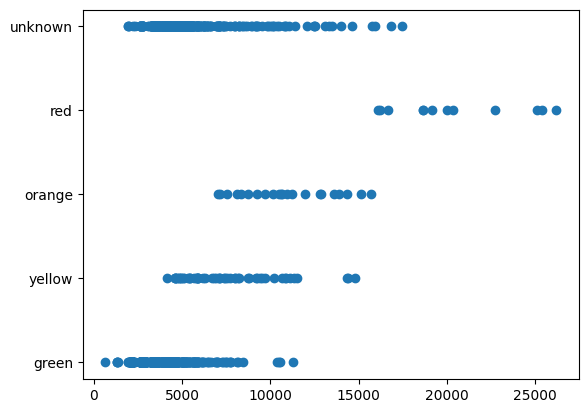

In [ ]:
def scatter_dependence(target: pd.Series, feature: pd.Series):
    target = target.fillna('unknown')
    target = target[~feature.isna()]
    feature = feature[~feature.isna()]
    plt.scatter(feature, target)
    plt.show()


scatter_dependence(df['alert'], df['sig'] * df['mmi'])


Мне кажется отстутствующие continent и country это просто точки в океане

In [ ]:
# Центр карты — средние координаты
center_lat = df["latitude"].mean()
center_lon = df["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color='gray' if isinstance(row['continent'], float) else 'green',
        fill=True,
        fill_color='gray' if isinstance(row['continent'], float) else 'green',
        fill_opacity=0.7,
        popup=f"Магнитуда: {row['magnitude']}, Alert: {row['alert']}"
    ).add_to(m)

m

# ЗЕЛЁНЫМ ОБОЗНАЧЕНЫ ТОЧКИ БЕЗ ПРОПУСКОВ
# СЕРЫМ - ТОЧКИ С ОТСУТСТВУЮЩИМ ЗНАЧЕНИЕМ `continent`


И да, и нет. Можно доопределить эти признаки, засчёт ближайших других записей. Тут подойдёт radius-NN

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier

df['continent_filled'] = df['continent'].copy()

train_mask = df['continent'].notna()
X_train = df.loc[train_mask, ['longitude', 'latitude']]
y_train = df.loc[train_mask, 'continent']

test_mask = df['continent'].isna()
X_test = df.loc[test_mask, ['longitude', 'latitude']]

knn_clf = RadiusNeighborsClassifier(radius=15, outlier_label='ocean')
knn_clf.fit(X_train, y_train)


RadiusNeighborsClassifier(outlier_label='ocean', radius=15)

In [ ]:
predicted_continents = knn_clf.predict(X_test)
df.loc[test_mask, 'continent_filled'] = predicted_continents


/home/matvey/workspace/ClassicML-Sem5/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:864: UserWarning: Outlier label ocean is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(


In [ ]:
# Центр карты — средние координаты
center_lat = df["latitude"].mean()
center_lon = df["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color='blue' if row['continent_filled'] == 'ocean' else 'gray',
        fill=True,
        fill_color='blue' if row['continent_filled'] == 'ocean' else 'gray',
        fill_opacity=0.7,
        popup=f"(lat, long): {(row['latitude'], row['longitude'])}, country: {row['continent_filled']}"
    ).add_to(m)

m

# СЕРЫМ ПОМЕЧЕНЫ ТОЧКИ С УКАЗАННым КОНТИНЕНТОМ
# СИНИМ ПОМЕЧЕНЫ ТОЧКИ В ОКЕАНЕ


Новую Зеландию не разметили. Давайте вручную пометим

In [ ]:
some = (-42.3205, 173.669)
df.loc[(df['latitude'] - some[0]).abs() < 0.01, 'continent'] = 'Oceania'


In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier

df['continent_filled'] = df['continent'].copy()

train_mask = df['continent'].notna()
X_train = df.loc[train_mask, ['longitude', 'latitude']]
y_train = df.loc[train_mask, 'continent']

test_mask = df['continent'].isna()
X_test = df.loc[test_mask, ['longitude', 'latitude']]

knn_clf = RadiusNeighborsClassifier(radius=15, outlier_label='ocean')
knn_clf.fit(X_train, y_train)

predicted_continents = knn_clf.predict(X_test)
df.loc[test_mask, 'continent_filled'] = predicted_continents

# Центр карты — средние координаты
center_lat = df["latitude"].mean()
center_lon = df["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color='blue' if row['continent_filled'] == 'ocean' else 'gray',
        fill=True,
        fill_color='blue' if row['continent_filled'] == 'ocean' else 'gray',
        fill_opacity=0.7,
        popup=f"(lat, long): {(row['latitude'], row['longitude'])}, country: {row['continent_filled']}"
    ).add_to(m)

m


/home/matvey/workspace/ClassicML-Sem5/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:864: UserWarning: Outlier label ocean is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(


In [ ]:
df.isna().sum()


title                 0
magnitude             0
date_time             0
cdi                   0
mmi                   0
alert               367
tsunami               0
sig                   0
net                   0
nst                   0
dmin                  0
gap                   0
magType               0
depth                 0
latitude              0
longitude             0
location              5
continent           575
country             298
continent_filled      0
dtype: int64

Со странами сложнее, и возможно не сильно нужно, но построим аналогичну, карту

In [ ]:
# Центр карты — средние координаты
center_lat = df["latitude"].mean()
center_lon = df["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color='gray' if isinstance(row['country'], float) else 'green',
        fill=True,
        fill_color='gray' if isinstance(row['country'], float) else 'green',
        fill_opacity=0.7,
        popup=f"(lat, long): {(row['latitude'], row['longitude'])}, country: {row['country']}"
    ).add_to(m)

m


Видно, что многие точки лежат рядом с другими точками, помеченными страной, но в нейтральных водах. То есть пропуски имеют смысл, но для модели это может быть немного неинтуитивным: одна точка имеет конкретную страну (область планеты), а очень близаая к ней точка не имеет конкретной страны и фактически усредняется по всем таким точкам. Попробуем добавить заполненный признак, а позже проверим как лучше: с признаком, заполненным меткой NoCountry, заполненным меткой ближайшей страны, и без признака

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier

df['country_filled'] = df['country'].copy()

train_mask = df['country'].notna()
X_train = df.loc[train_mask, ['longitude', 'latitude']]
y_train = df.loc[train_mask, 'country']

test_mask = df['country'].isna()
X_test = df.loc[test_mask, ['longitude', 'latitude']]

knn_clf = RadiusNeighborsClassifier(radius=8, outlier_label='NoCountry')
knn_clf.fit(X_train, y_train)

predicted_continents = knn_clf.predict(X_test)
df.loc[test_mask, 'country_filled'] = predicted_continents

# Центр карты — средние координаты
center_lat = df["latitude"].mean()
center_lon = df["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color='gray' if row['country_filled'] == 'NoCountry' else 'blue',
        fill=True,
        fill_color='gray' if row['country_filled'] == 'NoCountry' else 'blue',
        fill_opacity=0.7,
        popup=f"(lat, long): {(row['latitude'], row['longitude'])}, country: {row['country_filled']}"
    ).add_to(m)

m


/home/matvey/workspace/ClassicML-Sem5/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:864: UserWarning: Outlier label NoCountry is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(


In [ ]:
df.isna().sum()


title                 0
magnitude             0
date_time             0
cdi                   0
mmi                   0
alert               367
tsunami               0
sig                   0
net                   0
nst                   0
dmin                  0
gap                   0
magType               0
depth                 0
latitude              0
longitude             0
location              5
continent           575
country             298
continent_filled      0
country_filled        0
dtype: int64

Наконец, осталось разобраться с пропусками в alert. Это проблема, так как заполнение пропусков в таргете называется, в общем-то, разметкой, а мы не обладаем достаточной экспертизой для разметки. Однако можно использовать трюки semisupervised learning, например, псевдолейблинг

Сделаем бейзлайн модель - логистическая регрессия только на числовых признаках. Датасет маленький, будем использовать кросс-валидацию для оценки модели

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score


def evaluate_logistic_regression(dataset, target_column='alert'):
    # Подготовка фичей и таргета
    X = dataset.select_dtypes(include=['number']).to_numpy()
    y = dataset[target_column]

    # Удаление строк с пустыми метками
    mask = y.notna()
    X = X[mask]
    y = y[mask]

    # Конвертация меток в числовой формат
    class_order = ['red', 'orange', 'yellow', 'green']
    class_to_label = {cls: idx for idx, cls in enumerate(class_order)}
    y = y.map(class_to_label).to_numpy()

    # Удаление NaN из фичей
    non_nan_mask = ~np.isnan(X).any(axis=1)
    X = X[non_nan_mask]
    y = y[non_nan_mask]

    # Модель и кросс-валидация
    model = LogisticRegression(
        class_weight='balanced',
        max_iter=50_000,
        random_state=42,
        solver='newton-cg'
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    weights = np.array([4, 2, 1.5, 1]) / 4  # Нормализованные веса

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        accuracy_scores.append(accuracy_score(y_val, y_pred))
        p_per_class = precision_score(
            y_val, y_pred, labels=[0, 1, 2, 3], average=None, zero_division=0)
        r_per_class = recall_score(y_val, y_pred, labels=[
                                   0, 1, 2, 3], average=None, zero_division=0)

        precision_scores.append(np.average(p_per_class, weights=weights))
        recall_scores.append(np.average(r_per_class, weights=weights))

    # Вывод метрик
    print(f"Accuracy: {np.mean(accuracy_scores):.3f}")
    print(f"Weighted Precision: {np.mean(precision_scores):.3f}")
    print(f"Weighted Recall: {np.mean(recall_scores):.3f}")

    return np.mean(accuracy_scores), np.mean(precision_scores), np.mean(recall_scores)


In [ ]:
evaluate_logistic_regression(df, target_column='alert')


Accuracy: 0.800
Weighted Precision: 0.762
Weighted Recall: 0.859


(np.float64(0.8),
 np.float64(0.7621868809167562),
 np.float64(0.8587124640065816))

Теперь попробуем закодировать категориальные признаки

In [ ]:
df['continent_filled'].nunique()


7

Этот признак можно закодировать с помощью OHE, с ним проблем нет (добавится всего лишь шесть новых признаков)

In [ ]:
df['country_filled'].nunique()


50

С этим признаком проблемы: добавлять 49 новых признаков весело, но раздует модель. К тому же датасет слишком маленький, чтобы эти признаки качественно обучились.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Создаём новый датафрейм без исходного категориального признака
df_new = df.drop(columns=['country_filled']).copy()

# Функция для безопасного получения моды


def safe_mode(x):
    mode_vals = x.mode()
    return mode_vals.iloc[0] if len(mode_vals) > 0 else None

# Функция для энтропии (с защитой от log(0))


def entropy(series):
    counts = series.value_counts()
    probs = counts / len(series)
    return -np.sum(probs * np.log(probs + 1e-12))


# Группируем по country_filled и считаем статистики
group_stats = df.groupby('country_filled')['alert'].agg(
    # самый частый класс (без ошибок!)
    most_frequent_class=(safe_mode),
    # энтропия распределения классов
    country_class_entropy=(entropy)
).reset_index()

# Добавляем статистики к новому датафрейму
df_new = df_new.join(
    group_stats.set_index('country_filled'),
    on=df['country_filled'].values
)
df_new = df_new.drop(columns=['key_0', 'country'])

# Инициализируем OneHotEncoder с drop='first' (удаляет первый столбец)
ohe_country = OneHotEncoder(sparse_output=False, drop='first', dtype=float)

# Преобразуем признак
ohe_encoded = ohe_country.fit_transform(
    df_new[['most_frequent_class']].fillna('missing'))

# Получаем названия новых столбцов
ohe_columns = ohe_country.get_feature_names_out(['most_frequent_class'])

# Создаём DataFrame с закодированными признаками
ohe_df = pd.DataFrame(ohe_encoded, columns=ohe_columns, index=df_new.index)

# Удаляем исходный признак и добавляем OHE-столбцы
df_new = pd.concat([
    df_new.drop(columns=['most_frequent_class']),  # удаляем категорию
    ohe_df  # добавляем OHE-признаки
], axis=1)


In [ ]:
df_new.head()


title  magnitude         date_time  \
0  M 7.0 - 18 km SW of Malango, Solomon Islands        7.0  22-11-2022 02:03   
1      M 6.9 - 204 km SW of Bengkulu, Indonesia        6.9  18-11-2022 13:37   
2                                      M 7.0 -         7.0  12-11-2022 07:09   
3           M 7.3 - 205 km ESE of Neiafu, Tonga        7.3  11-11-2022 10:48   
4                                      M 6.6 -         6.6  09-11-2022 10:14   

   cdi  mmi  alert  tsunami  sig net  nst  ...  latitude  longitude  \
0    8    7  green        1  768  us  117  ...   -9.7963    159.596   
1    4    4  green        0  735  us   99  ...   -4.9559    100.738   
2    3    3  green        1  755  us  147  ...  -20.0508   -178.346   
3    5    5  green        1  833  us  149  ...  -19.2918   -172.129   
4    0    2  green        1  670  us  131  ...  -25.5948    178.278   

                   location  continent  continent_filled  \
0  Malango, Solomon Islands    Oceania           Oceania   
1       Bengkulu, Indonesia        NaN              Asia   
2                       NaN    Oceania           Oceania   
3             Neiafu, Tonga        NaN           Oceania   
4                       NaN        NaN             ocean   

   country_class_entropy most_frequent_class_missing  \
0               0.351909                         0.0   
1               0.526852                         0.0   
2               0.195467                         0.0   
3               0.195467                         0.0   
4               0.195467                         0.0   

  most_frequent_class_orange most_frequent_class_red  \
0                        0.0                     0.0   
1                        0.0                     0.0   
2                        0.0                     0.0   
3                        0.0                     0.0   
4                        0.0                     0.0   

   most_frequent_class_yellow  
0                         0.0  
1                         0.0  
2                         0.0  
3                         0.0  
4                         0.0  

[5 rows x 24 columns]

In [ ]:
evaluate_logistic_regression(df_new, target_column='alert')


Accuracy: 0.848
Weighted Precision: 0.785
Weighted Recall: 0.892


(np.float64(0.8481927710843372),
 np.float64(0.7846291290608058),
 np.float64(0.8915466886055121))

Теперь закодируем континент

In [ ]:
# Инициализируем OneHotEncoder с drop='first' (удаляет первый столбец)
ohe_continent = OneHotEncoder(sparse_output=False, drop='first', dtype=float)

# Преобразуем признак
ohe_encoded = ohe_continent.fit_transform(
    df_new[['continent_filled']].fillna('missing'))

# Получаем названия новых столбцов
ohe_columns = ohe_continent.get_feature_names_out(['continent_filled'])

# Создаём DataFrame с закодированными признаками
ohe_df = pd.DataFrame(ohe_encoded, columns=ohe_columns, index=df_new.index)

# Удаляем исходный признак и добавляем OHE-столбцы
df_new_2 = pd.concat([
    df_new.drop(columns=['continent_filled']),  # удаляем категорию
    ohe_df  # добавляем OHE-признаки
], axis=1)


In [ ]:
evaluate_logistic_regression(df_new_2, target_column='alert')


Accuracy: 0.841
Weighted Precision: 0.781
Weighted Recall: 0.888


(np.float64(0.8409638554216867),
 np.float64(0.7810732394262075),
 np.float64(0.8876141505553271))

Видим что качество стало хуже, но возможно проблема в том, что датасет слишком мал. Попробуем применить псевдолейблинг для разметки данных

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score


def pseudolabeling_step(dataset, target_column='alert', confidence_threshold=0.9, logging=True):
    """
    Выполняет один шаг псевдолейблирования:
    - Копирует датасет
    - Оставляет только числовые признаки
    - Разделяет на размеченные и неразмеченные данные
    - Обучает модель на размеченных
    - Предсказывает на неразмеченных и добавляет метки, если уверенность > threshold
    - Возвращает расширенный датасет и маску (True = оригинал, False = псевдолейбл)
    """
    # 1. Копируем датасет
    df = dataset.copy()

    # 2. Выбираем только числовые признаки
    feature_columns = df.select_dtypes(include=['number']).columns.tolist()
    X_all = df[feature_columns]

    # 3. Разделение по наличию таргета
    labeled_mask = df[target_column].notna()

    X_labeled = X_all[labeled_mask]
    y_labeled = df.loc[labeled_mask, target_column]

    X_unlabeled = X_all[~labeled_mask]

    # Пропускаем псевдолейблы, если нет неразмеченных или размеченных
    if len(X_labeled) == 0 or len(X_unlabeled) == 0:
        # Возвращаем оригинал
        return df, 0

    # Конвертация меток в числовой формат
    class_order = ['red', 'orange', 'yellow', 'green']
    class_to_label = {cls: idx for idx, cls in enumerate(class_order)}
    label_to_class = {idx: cls for cls, idx in class_to_label.items()}

    y_labeled_encoded = y_labeled.map(class_to_label).to_numpy()

    # Удаляем строки с NaN в фичах из размеченных
    non_nan_labeled_mask = ~np.isnan(X_labeled.to_numpy()).any(axis=1)
    X_labeled = X_labeled.iloc[non_nan_labeled_mask]
    y_labeled_encoded = y_labeled_encoded[non_nan_labeled_mask]

    # Проверим, остались ли данные после очистки
    if len(X_labeled) == 0:
        return df, 0

    # Подготовка неразмеченных: удаляем строки с NaN
    non_nan_unlabeled_mask = ~np.isnan(X_unlabeled.to_numpy()).any(axis=1)
    X_unlabeled_clean = X_unlabeled.iloc[non_nan_unlabeled_mask]
    clean_unlabeled_indices = X_unlabeled_clean.index

    if len(X_unlabeled_clean) == 0:
        return df, 0

    # 4. Обучение модели
    model = LogisticRegression(
        class_weight='balanced',
        max_iter=50_000,
        random_state=42,
        solver='newton-cg'
    )
    model.fit(X_labeled.to_numpy(), y_labeled_encoded)

    # 5. Предсказание вероятностей
    probas = model.predict_proba(X_unlabeled_clean.to_numpy())
    predictions = model.predict(X_unlabeled_clean.to_numpy())

    # 6. Фильтрация по порогу уверенности
    max_probas = np.max(probas, axis=1)
    confident_mask = max_probas >= confidence_threshold

    # Если нет уверенных предсказаний — возвращаем как есть
    if not confident_mask.any():
        return df, 0

    # Получаем индексы уверенных объектов
    final_unlabeled_indices = clean_unlabeled_indices[confident_mask]
    final_predictions = predictions[confident_mask]

    # Добавляем псевдолейблы в копию датасета
    pseudo_labels = [label_to_class[pred] for pred in final_predictions]
    df.loc[final_unlabeled_indices, target_column] = pseudo_labels

    if logging:
        print(f'Добавлено псевдометок: {np.sum(confident_mask)}')

    return df, np.sum(confident_mask)


def evaluate_logistic_regression(dataset, target_column='alert', mask=None, logging=True):
    """
    Оценка логистической регрессии.
    mask: True для оригинальных меток, False для псевдолейблов (один элемент на строку датасета).
    При обучении — все строки с меткой (оригинал + псевдо), при валидации — только оригинальные.
    """
    # Выбираем числовые фичи
    X = dataset.select_dtypes(include=['number'])
    y = dataset[target_column].copy()

    # Преобразуем метки
    class_order = ['red', 'orange', 'yellow', 'green']
    class_to_label = {cls: idx for idx, cls in enumerate(class_order)}
    y = y.map(class_to_label)

    # Создаём маску наличия метки (не NaN)
    labeled_mask = y.notna()

    # Если передана внешняя mask, она должна быть той же длины, что и датасет
    if mask is None:
        mask = labeled_mask.astype(bool)  # Все имеющиеся метки — оригинальные
    else:
        # Убедимся, что mask — это pd.Series или np.array той же длины
        if isinstance(mask, np.ndarray):
            mask = pd.Series(mask, index=dataset.index)
        mask = mask & labeled_mask  # Только где есть метка и она считается "оригинальной"

    # Объединяем данные
    data = X.assign(target=y).copy()

    # Удаляем строки, где target NaN
    data = data[labeled_mask]
    mask = mask[labeled_mask]  # Теперь mask соответствует data

    # Удаляем строки с NaN в фичах
    feature_columns = X.columns
    non_nan_features = data[feature_columns].notna().all(axis=1)
    data = data[non_nan_features]
    mask = mask[non_nan_features]

    X_clean = data[feature_columns].to_numpy()
    y_clean = data['target'].to_numpy()
    mask_clean = mask.values  # Теперь это numpy-массив после всех фильтраций

    # Проверяем, остались ли оригинальные метки для валидации
    if not mask_clean.any():
        if logging:
            print("Нет оригинальных меток для валидации!")
        return 0.0, 0.0, 0.0

    # Модель
    model = LogisticRegression(
        class_weight='balanced',
        max_iter=50_000,
        random_state=42,
        solver='newton-cg'
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    weights = np.array([4, 2, 1.5, 1])
    weights = weights / weights.sum()  # [0.4706, 0.2353, 0.1765, 0.1176]

    # Кросс-валидация
    for train_idx, val_idx in skf.split(X_clean, y_clean):
        # Обучение: используем ВСЕ метки из train (включая псевдолейблы)
        X_train = X_clean[train_idx]
        y_train = y_clean[train_idx]

        # Валидация: только оригинальные метки (где mask == True)
        val_original_indices = [i for i in val_idx if mask_clean[i]]
        if len(val_original_indices) == 0:
            continue

        X_val = X_clean[val_original_indices]
        y_val = y_clean[val_original_indices]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        accuracy_scores.append(accuracy_score(y_val, y_pred))

        p_per_class = precision_score(
            y_val, y_pred, labels=[0, 1, 2, 3], average=None, zero_division=0)
        r_per_class = recall_score(y_val, y_pred, labels=[
                                   0, 1, 2, 3], average=None, zero_division=0)

        precision_scores.append(np.average(p_per_class, weights=weights))
        recall_scores.append(np.average(r_per_class, weights=weights))

    acc_mean = np.mean(accuracy_scores) if accuracy_scores else 0.0
    prec_mean = np.mean(precision_scores) if precision_scores else 0.0
    rec_mean = np.mean(recall_scores) if recall_scores else 0.0

    if logging:
        print(f"Accuracy: {acc_mean:.3f}")
        print(f"Weighted Precision: {prec_mean:.3f}")
        print(f"Weighted Recall: {rec_mean:.3f}")

    return acc_mean, prec_mean, rec_mean


In [ ]:
df_current = df_new.copy()
for i in range(5):
    print(f"--- Iteration {i+1} ---")
    df_current, _ = pseudolabeling_step(df_current, confidence_threshold=0.98)
    evaluate_logistic_regression(df_current, mask=df_new['alert'].notna())


--- Iteration 1 ---
Добавлено псевдометок: 98
Accuracy: 0.845
Weighted Precision: 0.784
Weighted Recall: 0.869
--- Iteration 2 ---
Добавлено псевдометок: 9
Accuracy: 0.846
Weighted Precision: 0.794
Weighted Recall: 0.898
--- Iteration 3 ---
Добавлено псевдометок: 5
Accuracy: 0.840
Weighted Precision: 0.792
Weighted Recall: 0.863
--- Iteration 4 ---
Добавлено псевдометок: 4
Accuracy: 0.855
Weighted Precision: 0.797
Weighted Recall: 0.891
--- Iteration 5 ---
Добавлено псевдометок: 1
Accuracy: 0.843
Weighted Precision: 0.806
Weighted Recall: 0.896


Как видим, без учёта континента, но с псевдолейблингом, получилось улучшить качество. Давайте попробуем учесть континент

In [ ]:
from sklearn.metrics import f1_score
from tqdm import tqdm

df_current = df_new_2.copy()

# Список для логирования результатов
results_log = []

print("=== Smart Pseudo-Labeling with Recall Optimization ===\n")

n_iterations = 5
for i in range(n_iterations):
    print(f"--- Iteration {i+1}/{n_iterations} ---")

    best_rec = 0
    best_df = df_current.copy()
    best_threshold = 0.89
    best_metrics = {}
    best_cnt_pseudo = 0

    # Перебираем пороги
    for thr in tqdm(np.linspace(0.89, 0.99, 10)):
        df_candidate = df_current.copy()  # копируем текущий датасет
        df_candidate, cnt_pseudo = pseudolabeling_step(
            df_candidate, confidence_threshold=thr, logging=False)

        acc, prec, rec = evaluate_logistic_regression(
            df_candidate, mask=df_new['alert'].notna(), logging=False)

        # Обновляем лучший результат
        if rec > best_rec:
            best_rec = rec
            best_df = df_candidate
            best_threshold = thr
            best_metrics = {'acc': acc, 'prec': prec, 'rec': rec}
            best_cnt_pseudo = cnt_pseudo

    # После перебора всех порогов — фиксируем лучший вариант
    df_current = best_df  # переходим к лучшему датасету
    results_log.append({
        'iteration': i+1,
        'best_threshold': best_threshold,
        'precision': best_metrics['prec'],
        'recall': best_metrics['rec'],
        'accuracy': best_metrics['acc'],
        'pseudo_labels_added': best_cnt_pseudo
    })

    # Вывод лучшего результата на итерации
    print(f"Best threshold: {best_threshold:.3f}")
    print(f"Prec: {best_metrics['prec']:.4f},\n"
          f"Rec: {best_metrics['rec']:.4f},\n"
          f"Acc: {best_metrics['acc']:.4f}")
    print(f"Added pseudo-labels: {best_cnt_pseudo}\n")

    if best_cnt_pseudo == 0:
        break


=== Smart Pseudo-Labeling with Recall Optimization ===

--- Iteration 1/5 ---


100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


Best threshold: 0.990
Prec: 0.8034,
Rec: 0.9044,
Acc: 0.8543
Added pseudo-labels: 73

--- Iteration 2/5 ---


100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


Best threshold: 0.979
Prec: 0.8059,
Rec: 0.8981,
Acc: 0.8602
Added pseudo-labels: 43

--- Iteration 3/5 ---


100%|██████████| 10/10 [00:22<00:00,  2.25s/it]

Best threshold: 0.990
Prec: 0.8059,
Rec: 0.8981,
Acc: 0.8602
Added pseudo-labels: 0



Удалось добиться ещё небольшого прироста в качестве